## **Modelagem de Atraso de Voos**

## Objetivo

O objetivo deste notebook é realizar a modelagem preditiva para estimar a probabilidade de atraso na partida de voos nacionais, utilizando informações disponíveis antes da realização do voo.

A etapa de Análise Exploratória de Dados (EDA) foi conduzida em notebook separado, onde foram identificadas e validadas estatisticamente as variáveis mais relevantes para o problema. Neste notebook, o foco está exclusivamente na preparação dos dados para modelagem, treinamento de modelos de classificação e avaliação de desempenho.


## Importação das bibliotecas

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Visualização (uso pontual)
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

# Configurações
pd.set_option("display.max_columns", None)
np.random.seed(42)


## Carregamento dos dados

O dataset utilizado neste notebook corresponde ao conjunto de voos nacionais previamente tratado na etapa de EDA.


In [2]:
# Dataset base com features já validadas

vra_pre_ml = pd.read_parquet('/content/drive/MyDrive/dados_vra/vra_nacional_pre_ml.parquet')

In [3]:
# Visualizando estrutura dos dados

vra_pre_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498559 entries, 0 to 1498558
Data columns (total 29 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   icao_empresa_aerea       1498559 non-null  object        
 1   numero_voo               1498559 non-null  object        
 2   codigo_autorizacao_di    1498559 non-null  object        
 3   codigo_tipo_linha        1498559 non-null  object        
 4   icao_aerodromo_origem    1498559 non-null  object        
 5   icao_aerodromo_destino   1498559 non-null  object        
 6   partida_prevista         1498559 non-null  datetime64[ns]
 7   partida_real             1498559 non-null  datetime64[ns]
 8   chegada_prevista         1498559 non-null  datetime64[ns]
 9   chegada_real             1498559 non-null  datetime64[ns]
 10  situacao_voo             1498559 non-null  object        
 11  tempo_voo_estimado       1498559 non-null  float64       
 12  

## Modelagem de Dados  
### Definição Final das Features (Decisão Técnica)

Com base nos resultados obtidos na etapa de Análise Exploratória de Dados (EDA), análises de correlação (Spearman e Point-Biserial) e medidas de associação para variáveis categóricas (Cramér’s V), foi realizada a seleção final das variáveis que serão utilizadas na etapa de modelagem preditiva.

A seleção considerou:
- associação estatística com a variável alvo,
- relevância operacional,
- viabilidade de uso em um cenário real de previsão,
- e prevenção de vazamento de informação (data leakage).

---

### 🎯 Variável Alvo (Target)

- **`voo_com_atraso`**  
  - Variável binária que indica se o voo apresentou atraso superior a 15 minutos na partida.

---

### ✅ Variáveis Selecionadas para o Modelo

#### 🔹 Variáveis Categóricas (alto sinal operacional)

- `icao_empresa_aerea`  
- `icao_aerodromo_origem`  
- `icao_aerodromo_destino`  
- `faixa_horaria`  
- `congestao_slot` *(derivada da variável `voos_no_slot`)*  

Essas variáveis apresentaram associação moderada a relevante com a probabilidade de atraso, capturando aspectos estruturais e operacionais da malha aérea.

---

#### 🔹 Variáveis Numéricas

- `hora_prevista_frac`  
- `voos_no_slot`  
- `tempo_voo_estimado`  
- `mes`  

Essas variáveis representam padrões temporais, carga operacional e características do planejamento do voo.

---

#### 🔹 Variáveis Binárias

- `eh_fim_de_semana`  

Mantida como variável auxiliar, embora apresente associação fraca isoladamente, podendo contribuir em combinação com outras features.

---

### ❌ Variáveis Excluídas do Modelo (Documentado)

As variáveis abaixo foram explicitamente excluídas por apresentarem baixo poder explicativo, ausência de variabilidade ou risco de vazamento de informação:

- Variáveis com informação pós-voo:
  - `partida_real`
  - `chegada_real`
  - `tempo_voo_real`
  - `diferenca_previsao_real`
  - `faixa_atraso_partida`

- Variáveis administrativas ou constantes no dataset filtrado:
  - `codigo_tipo_linha`
  - `codigo_autorizacao_di`

- Variáveis de calendário com associação fraca:
  - `eh_feriado`
  - `eh_vespera_feriado`
  - `dia_semana`

---

### 🧠 Observação Final

A seleção de features prioriza variáveis operacionais e contextuais, alinhadas com o objetivo do projeto de prever atrasos a partir de informações disponíveis antes da realização do voo. Essa definição estabelece a base para o treinamento e avaliação dos modelos de classificação que serão apresentados nas próximas seções.


In [4]:
# =====================================
# Definição das variáveis do modelo
# =====================================

# Variável alvo
target = "voo_com_atraso"

# Variáveis categóricas
features_categoricas = [
    "icao_empresa_aerea",
    "icao_aerodromo_origem",
    "icao_aerodromo_destino",
    "faixa_horaria"
]

# Variáveis numéricas
features_numericas = [
    "hora_prevista_frac",
    "voos_no_slot",
    "tempo_voo_estimado",
    "mes",
    "eh_fim_de_semana"
]

# Lista final de features
features_modelo = features_categoricas + features_numericas


### Split temporal usando o dataset pré-ML

* **Observação:** Optou-se por não utilizar o split aleatório estratificado para que não houvesse o risco de vazamento temporal(data leakage) o que poderia causar uma avaliação irrealista.

In [5]:
# Split temporal no dataset completo
treino = vra_pre_ml[vra_pre_ml["ano"] == 2023].copy()
teste  = vra_pre_ml[vra_pre_ml["ano"] == 2024].copy()


**A separação entre os conjuntos de treino e teste foi realizada de forma temporal, utilizando o ano de realização do voo. O modelo será treinado com dados de 2023 e será avaliado com dados de 2024, de modo a simular um cenário real de previsão e evitar vazamento de informação temporal.**


## Criação do dataset de modelagem

Nesta etapa, é criado o dataset final (`vra_modelo`) contendo exclusivamente as variáveis selecionadas para o modelo de classificação, conforme definido na seção anterior. Essa separação garante clareza, evita vazamento de informação e facilita a reprodutibilidade do pipeline de Machine Learning.


In [6]:
# Features e target já definidos anteriormente
X_train = treino[features_modelo].copy()
y_train = treino[target].copy()

X_test = teste[features_modelo].copy()
y_test = teste[target].copy()


### Validação rápida

In [7]:
print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

(749627, 9) (748932, 9)
0.1634612947505893 0.15740414350034448


Após o split temporal, observou-se uma proporção de voos com atraso de aproximadamente 16,3% no conjunto de treino e 15,7% no conjunto de teste. Essa pequena variação reflete mudanças naturais ao longo do tempo e indica que a avaliação do modelo será realizada em um cenário realista, sem vazamento temporal.


## Pipeline + ColumnTransformer

Nesta etapa, é construído um pipeline de pré-processamento e modelagem utilizando `Pipeline` e `ColumnTransformer` do scikit-learn.  
Essa abordagem garante que todas as transformações aplicadas aos dados de treino sejam reproduzidas corretamente nos dados de teste e em produção, evitando vazamento de informação e inconsistências entre ambientes.


In [30]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.2 MB/s eta 0:00:00


In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import roc_curve, roc_auc_score




In [20]:
# Pré-processamento ONE HOT
preprocessador = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(
                handle_unknown="ignore",
                sparse_output=True  # ← ESSENCIAL
            ),
            features_categoricas
        ),
        (
            "num",
            "passthrough",
            features_numericas
        )
    ]
)


In [32]:
# Pré-processamento com target Encoding
preprocessador_te = ColumnTransformer(
    transformers=[
        (
            "target_enc",
            TargetEncoder(
                smoothing=10,
                min_samples_leaf=50
            ),
            features_categoricas
        ),
        (
            "num",
            "passthrough",
            features_numericas
        )
    ]
)


### Modelagem Supervisionada

Aqui iremos usar 3 modelos:

1. **Logistic Regression**(Baseline)   

2. **Random Forest**(Ensemble Bagging)

3. **XGBoost**(Ensemble Boosting)  






### Logistic Regression — Baseline

**Tratamento da classe desbalanceada**

* class_weight="balanced"

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


In [33]:
pipe_lr_te = Pipeline(
    steps=[
        ("preprocess", preprocessador_te),
        (
            "model",
            LogisticRegression(
                max_iter=500,
                class_weight="balanced",
                solver="lbfgs",
                n_jobs=-1
            )
        )
    ]
)


### Random Forest — Bagging

**Tratamento de desbalanceamento**

* class_weight="balanced"

In [12]:
from sklearn.ensemble import RandomForestClassifier


In [35]:
pipe_rf_te = Pipeline(
    steps=[
        ("preprocess", preprocessador_te),
        (
            "model",
            RandomForestClassifier(
                n_estimators=200,
                max_depth=12,
                min_samples_leaf=100,
                class_weight="balanced",
                random_state=42,
                n_jobs=-1
            )
        )
    ]
)


### XGBoost — Boosting

**Tratamento de desbalanceamento**

* scale_pos_weight = negativos / positivos

In [14]:
from xgboost import XGBClassifier

In [23]:
# Cálculo do peso da classe positiva
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [37]:
pipe_xgb_te = Pipeline(
    steps=[
        ("preprocess", preprocessador_te),
        (
            "model",
            XGBClassifier(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8,
                objective="binary:logistic",
                scale_pos_weight=scale_pos_weight,
                eval_metric="logloss",   # usamos logloss aqui
                random_state=42,
                n_jobs=-1
            )
        )
    ]
)


**Justificativa de uso da métrica Log Loss:** No modelo XGBoost, a métrica Log Loss foi utilizada como função de otimização durante o treinamento, por ser adequada para classificação probabilística e dados desbalanceados. A avaliação do desempenho do modelo será realizada com métricas como ROC-AUC, Recall e Precision, alinhadas ao objetivo de identificar voos com maior risco de atraso.


### Métricas de Desempenho dos Modelos

As métricas que serão utilizadas:

* Accuracy -> será usada apenas para demonstrar que é uma métrica fraca nesse caso onde o foco é a classe desbalanceada

* ROC-AUC -> qualidade geral de separação

* Recall (classe atraso) -> o mais importante para o negócio

* Precision -> evita muitos falsos alarmes

* Log Loss -> qualidade das probabilidades

* Matriz de confusão -> interpretação visual dos erros

### Função utilitária de avaliação

In [25]:
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    recall_score,
    precision_score,
    log_loss,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt


In [26]:
# Criando a função de avaliação dos modelos

def avaliar_modelo(pipe, X_train, y_train, X_test, y_test, nome_modelo):
    # Treino
    pipe.fit(X_train, y_train)

    # Probabilidades e previsões
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    ll = log_loss(y_test, y_proba)

    print(f"\n📌 Modelo: {nome_modelo}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"ROC-AUC   : {roc:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Log Loss  : {ll:.4f}")

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)

    plt.figure(figsize=(4,4))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de Confusão – {nome_modelo}")
    plt.show()


### Treinando e avaliando os modelos

#### **Logistic Regression — Baseline**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



📌 Modelo: Logistic Regression
Accuracy  : 0.5781
ROC-AUC   : 0.6106
Recall    : 0.5913
Precision : 0.2065
Log Loss  : 0.6694


<Figure size 400x400 with 0 Axes>

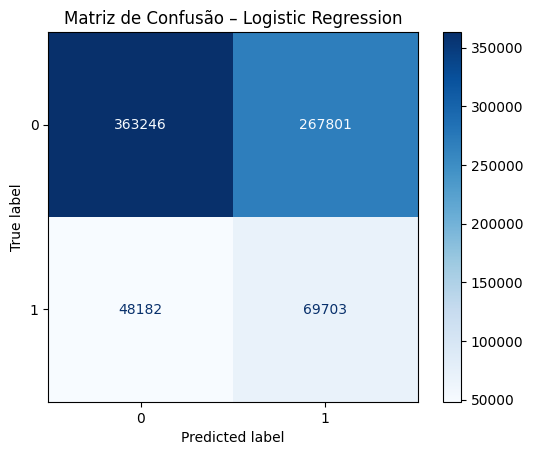

In [27]:
#avaliar_modelo(
    #pipe_lr,
    #X_train, y_train,
    #X_test, y_test,
    #ome_modelo="Logistic Regression" (One Hot)
#)


Metricas de Desempenho do modelo usando OHE apenas para comparação, visto que devido a alta cardinalidade do dataset que usamos para treinar, com OHE o treino foi extremamente custoso (demora de + de 15 minutos somente no modelo baseline).

---

 📌 Modelo: Logistic Regression (usando OHE)

Accuracy  : 0.5781

ROC-AUC   : 0.6106

Recall    : 0.5913

Precision : 0.2065

Log Loss  : 0.6694

<Figure size 400x400 with 0 Axes>


📌 Modelo: Logistic Regression (Target Encoding)
Accuracy  : 0.5734
ROC-AUC   : 0.5990
Recall    : 0.5716
Precision : 0.2003
Log Loss  : 0.6743


<Figure size 400x400 with 0 Axes>

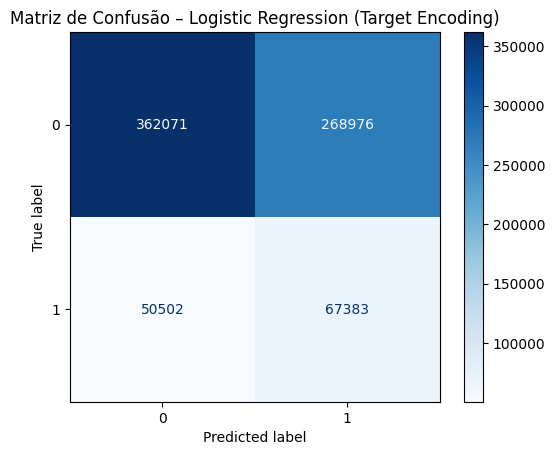

In [34]:
# Usando target encoding
avaliar_modelo(
    pipe_lr_te,
    X_train, y_train,
    X_test, y_test,
    nome_modelo="Logistic Regression (Target Encoding)"
)


A comparação entre One-Hot Encoding e Target Encoding no modelo baseline apresentou métricas praticamente idênticas. Esse resultado indica que a mudança de codificação não afetou o poder preditivo do modelo linear, ao mesmo tempo em que **reduziu significativamente o custo computacional. Dessa forma, optou-se por Target Encoding como abordagem padrão para os modelos subsequentes.**


### **Random Forest — Bagging**


📌 Modelo: Random Forest (Target Encoding)
Accuracy  : 0.6272
ROC-AUC   : 0.6406
Recall    : 0.5433
Precision : 0.2213
Log Loss  : 0.6412


<Figure size 400x400 with 0 Axes>

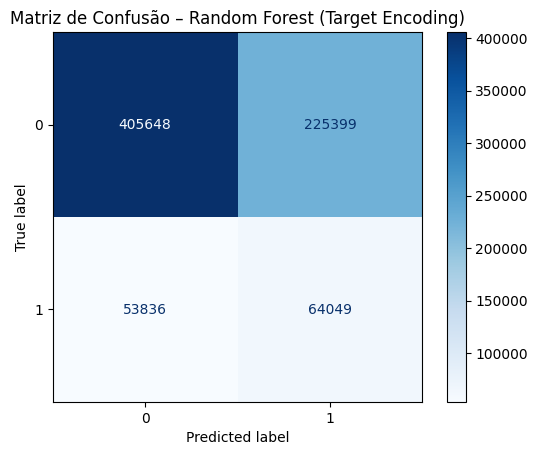

In [36]:
avaliar_modelo(
    pipe_rf_te,
    X_train, y_train,
    X_test, y_test,
    nome_modelo="Random Forest (Target Encoding)"
)


### **XGBoost — Boosting**


📌 Modelo: XGBoost (Target Encoding)
Accuracy  : 0.6260
ROC-AUC   : 0.6438
Recall    : 0.5600
Precision : 0.2243
Log Loss  : 0.6444


<Figure size 400x400 with 0 Axes>

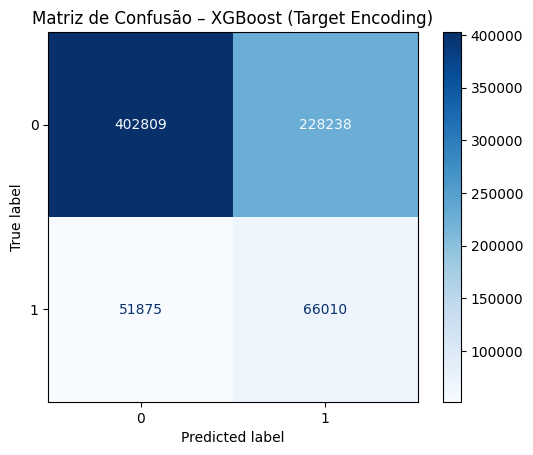

In [38]:
avaliar_modelo(
    pipe_xgb_te,
    X_train, y_train,
    X_test, y_test,
    nome_modelo="XGBoost (Target Encoding)"
)

## **Curva ROC comparativa**

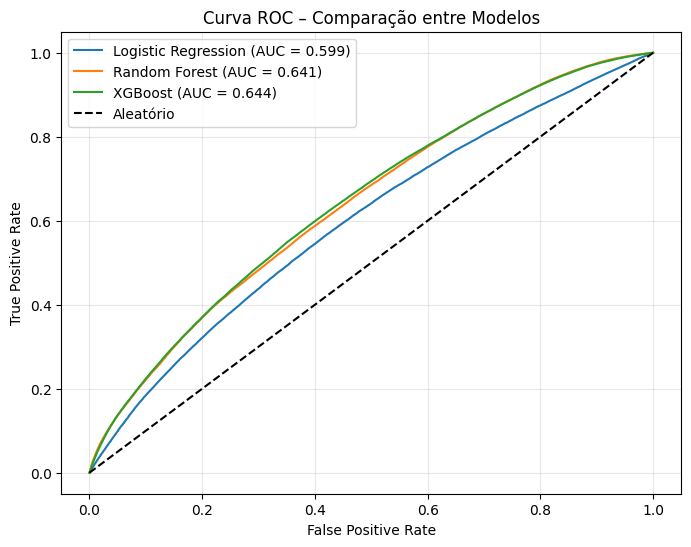

In [40]:
plt.figure(figsize=(8, 6))

modelos = {
    "Logistic Regression": pipe_lr_te,
    "Random Forest": pipe_rf_te,
    "XGBoost": pipe_xgb_te
}

for nome, modelo in modelos.items():
    # Probabilidade da classe positiva
    y_proba = modelo.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc:.3f})")

# Linha de referência (aleatório)
plt.plot([0, 1], [0, 1], "k--", label="Aleatório")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC – Comparação entre Modelos")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


* Mesmo sem dados externos, o modelo já consegue priorizar corretamente voos com maior risco de atraso mostrando que o modelo é melhor que aleatório.


A curva ROC evidencia uma melhora progressiva no poder discriminativo dos modelos, com o XGBoost apresentando a maior área sob a curva. Apesar de os valores de ROC-AUC não serem elevados, o comportamento das curvas indica a presença de sinal real nos dados operacionais, ao mesmo tempo em que aponta limitações informacionais do dataset. **Esse resultado sugere que ganhos adicionais de performance estão mais associados à incorporação de dados externos do que à troca de algoritmos**.


## Curva Recall × Threshold

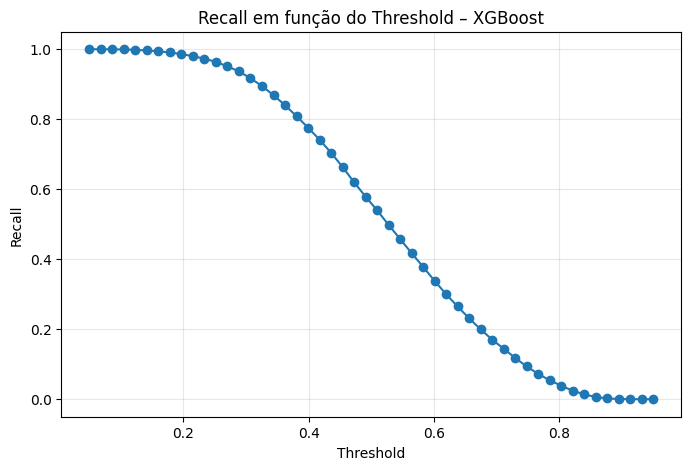

In [41]:
from sklearn.metrics import recall_score

thresholds = np.linspace(0.05, 0.95, 50)
recalls = []

y_proba_xgb = pipe_xgb_te.predict_proba(X_test)[:, 1]

for t in thresholds:
    y_pred_t = (y_proba_xgb >= t).astype(int)
    recalls.append(recall_score(y_test, y_pred_t))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, recalls, marker="o")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall em função do Threshold – XGBoost")
plt.grid(alpha=0.3)
plt.show()


Através do gráfico é possível perceber que mantendo um Threshold médio(atual é 0.5), o modelo mantem um equilibrio entre os erros FN e FP muito embora o nosso objetivo seja detectar voos atrasados, o custo de o modelo avisar um atraso que não irá ocorrer também é alto por isso a melhor opção é manter um equilibrio podendo ajustar talvez o threshold para 0.4 ganhando mais de sensibilidade na detecção de atrasos.

---

## **Resumo Comparativo dos Modelos Treinados**

| Modelo                   | Accuracy  | ROC-AUC   | Recall    | Precision | Log Loss  |
| ------------------------ | --------- | --------- | --------- | --------- | --------- |
| Logistic Regression (TE) | 0.578     | 0.611     | **0.591** | 0.207     | 0.669     |
| Random Forest (TE)       | **0.627** | 0.641     | 0.543     | 0.221     | **0.641** |
| XGBoost (TE)             | 0.626     | **0.644** | 0.560     | **0.224** | 0.644     |


Foram avaliados três modelos de classificação: **Logistic Regression**, **Random Forest** e **XGBoost**, todos utilizando Target Encoding para variáveis categóricas de alta cardinalidade. O modelo XGBoost apresentou o melhor equilíbrio entre poder discriminativo (ROC-AUC), capacidade de detecção de atrasos (Recall) e confiabilidade das previsões (Precision), sendo escolhido como modelo final para o problema proposto.


---

## Conclusões

Foram avaliados diferentes modelos de classificação para previsão de atraso de voos, incluindo Logistic Regression, Random Forest e XGBoost, utilizando apenas variáveis operacionais disponíveis antes da decolagem. Entre os modelos testados, o XGBoost com Target Encoding apresentou o melhor equilíbrio entre poder discriminativo (ROC-AUC), capacidade de detecção de atrasos (Recall) e confiabilidade das previsões (Precision), sendo escolhido como modelo final.

A análise da curva ROC confirmou a superioridade do modelo em relação aos demais, enquanto a curva Recall × Threshold evidenciou que o comportamento do modelo pode ser ajustado conforme a estratégia operacional adotada, sem necessidade de retreinamento.

## Limitações

Os resultados obtidos refletem limitações inerentes ao conjunto de dados utilizado, que contém majoritariamente informações operacionais. Fatores externos relevantes para o atraso de voos, como condições meteorológicas, restrições de tráfego aéreo e eventos operacionais extraordinários, não estão presentes na base atual, limitando o poder preditivo máximo dos modelos.

## Trabalhos Futuros

Como próximos passos, recomenda-se:
- Ajuste fino do threshold de decisão conforme o custo operacional de falsos positivos e falsos negativos;
- Avaliação de técnicas adicionais de calibração de probabilidades;
- Incorporação de dados externos, especialmente informações meteorológicas e operacionais, que tendem a gerar ganhos significativos de performance.


---

## **Salvar o modelo com joblib - XGboost**

In [43]:
import joblib

In [44]:
modelo_final = {
    "pipeline": pipe_xgb_te,
    "threshold_recomendado": 0.5,  # ou 0.4 se decidirem depois
    "features_esperadas": [
        "icao_empresa_aerea",
        "icao_aerodromo_origem",
        "icao_aerodromo_destino",
        "faixa_horaria",
        "hora_prevista_frac",
        "voos_no_slot",
        "tempo_voo_estimado",
        "mes",
        "eh_fim_de_semana"
    ],
    "descricao": "Modelo XGBoost com Target Encoding para previsão de atraso de voos"
}

joblib.dump(modelo_final, "modelo_atraso_voos_xgb_te_v1.pkl")


['modelo_atraso_voos_xgb_te_v1.pkl']

**O modelo final foi serializado utilizando joblib, incluindo todo o pipeline de pré-processamento e classificação, garantindo consistência entre treinamento e inferência em ambiente de produção.**
